## Conclusiones
* Fueron usados 3 modelos de Machine Learning para predecir los puntajes de shows de Netflix a partir del año de estreno y duración de las películas. El mejor modelo fue el de Regresión polinomial con un R cuadrado de 0.16. Es decir, el modelo puede explicar aproximadamente el 16% de la variación de los valores del Rating. 
* El modelo sugiere que la duración y el año de estreno tienen un impacto significativo en el rating.
* La información podría ser de ayuda para Netflix en su selección de contenido y estrategias de Marketing para estimar el potencial de éxito de sus películas según la fecha de estreno


### Librerías

In [215]:
import pandas as pd; import numpy as np; import matplotlib.pyplot as plt; import seaborn as sns

### Preprocesamiento

In [216]:
##-----Cantidad de valores nulos por columna y su porcentaje respecto al total

df = pd.read_csv('netflix_titles.csv')

def missing_values(df):
    duplicados = df.duplicated().sum()
    print(f'El Dataframe tiene {df.shape[0]} registros y {duplicados} valores duplicados'.center(70, '-'))
    print('')
    for i,col in enumerate(df):
        missing = df[col].isna().sum()
        missing_percentage = df[col].isna().sum()/df.shape[0]*100
        print(f'La columna {col} tiene << {missing} ({missing_percentage:.2f}%) >> valores nulos.')

missing_values(df)

##Eliminar las columnas innecesarias
df = df.drop(columns=['show_id','description','title'])

-------El Dataframe tiene 8807 registros y 0 valores duplicados-------

La columna show_id tiene << 0 (0.00%) >> valores nulos.
La columna type tiene << 0 (0.00%) >> valores nulos.
La columna title tiene << 0 (0.00%) >> valores nulos.
La columna director tiene << 2634 (29.91%) >> valores nulos.
La columna cast tiene << 825 (9.37%) >> valores nulos.
La columna country tiene << 831 (9.44%) >> valores nulos.
La columna date_added tiene << 10 (0.11%) >> valores nulos.
La columna release_year tiene << 0 (0.00%) >> valores nulos.
La columna rating tiene << 4 (0.05%) >> valores nulos.
La columna duration tiene << 3 (0.03%) >> valores nulos.
La columna listed_in tiene << 0 (0.00%) >> valores nulos.
La columna description tiene << 0 (0.00%) >> valores nulos.


In [217]:
##-----Llenar valores nulos con la media y la moda.
cat = df.select_dtypes('O')
num = df.select_dtypes('number')

for i, col in enumerate(cat):
    cat[col] = cat[col].fillna(cat[col].mode()[0])

for i, col in enumerate(num):
    num[col] = num[col].fillna(num[col].mean())

df[cat.columns] = cat
df[num.columns] = num

##-----Conversión de tipos de datos.
#-------La columna date_added debería ser tipo fecha pero es necesario hacer una correción antes
df['date_added']=df['date_added'].str.strip(' ')
df['date_added'] = pd.to_datetime(df['date_added'],format='%B %d, %Y')

df['release_year'] = df['release_year'].astype(np.int16)

##Obtener columna de años desde estreno hasta lanzamiento en netlix

df['year_to_netflix'] = df['date_added'].dt.year - df['release_year']

### Estilos para los gráficos

In [218]:
#-------------------------Estilos para los gráficos
import matplotlib as mpl
plt.style.use("fivethirtyeight") 
mpl.rcParams["font.size"]=10.5 
mpl.rcParams["legend.fontsize"]=14
mpl.rcParams["font.family"]="serif"
mpl.rcParams["font.weight"]="bold"
mpl.rcParams["legend.fancybox"]=True
mpl.rcParams["xtick.labelsize"]=10
mpl.rcParams["ytick.labelsize"]=16
mpl.rcParams["figure.titleweight"]="bold"
mpl.rcParams["axes.labelweight"]="bold"
mpl.rcParams["figure.facecolor"]="white"
mpl.rcParams["axes.facecolor"]="white"
mpl.rcParams["axes.edgecolor"]="0.2"
mpl.rcParams["axes.linewidth"]=1
mpl.rcParams["axes.titleweight"]="bold"
mpl.rcParams["axes.labelsize"]=16
mpl.rcParams["figure.titlesize"]=20
mpl.rcParams["axes.titlesize"]=25
mpl.rcParams["figure.labelsize"]=16
mpl.rcParams["figure.labelweight"]="bold"
mpl.rcParams['axes.grid']=False

In [219]:
##-----Descartar valores atípicos en base al año de estreno

q1 = df['release_year'].quantile(0.25)
q3 = df['release_year'].quantile(0.75)

iqr = q3 - q1

df = df.loc[(df['release_year']>=q1-1.5*iqr)&(df['release_year']<=q3+1.5*iqr)]

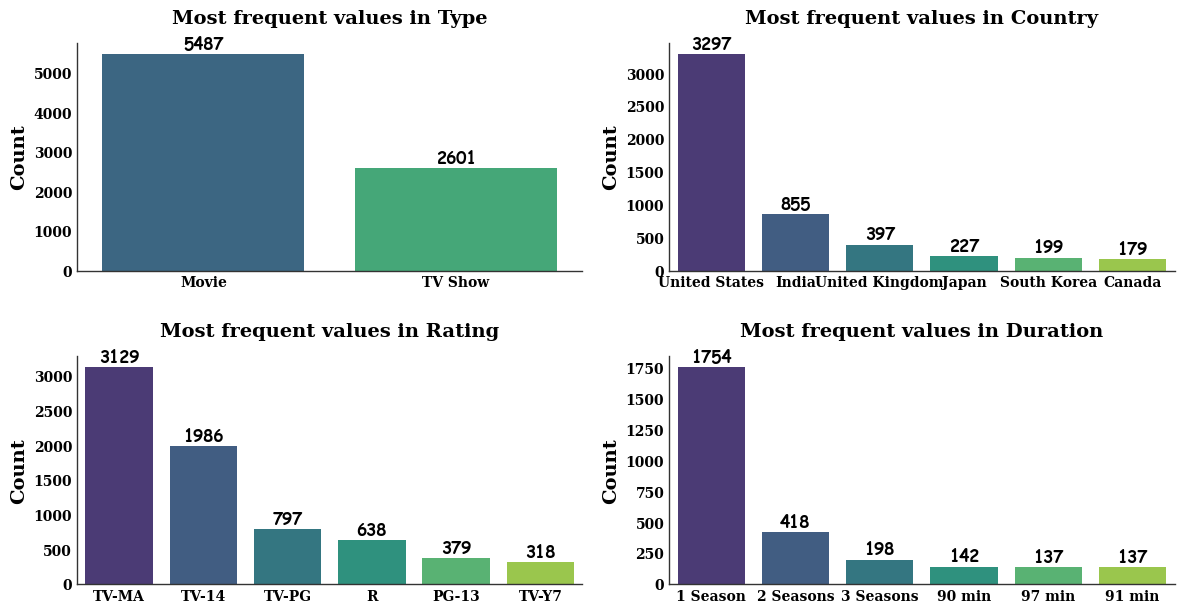

In [220]:
##-----Distribución de los datos
cols_borrar = ['director','cast','listed_in']
cat = df.select_dtypes('O').drop(columns=cols_borrar)


fig, ax = plt.subplots(figsize=(12,6),ncols=2,nrows=round(cat.shape[1]/2))
fig.tight_layout(h_pad=4)
ax = ax.flat

for i, col in enumerate(cat):
    
    conteo = cat[col].value_counts(sort=True).reset_index().head(6)
    bar = sns.barplot(data=conteo,x=col,y='count',ax=ax[i],hue=col,palette='viridis')
    for container in bar.containers:
        bar.bar_label(container,fontsize=12,fontfamily='cursive',fontweight='bold')

    ax[i].set_xlabel('')
    ax[i].set_ylabel('Count',fontdict=dict(weight='bold',size=14))
    ax[i].set_title('Most frequent values in' + f' {col}'.title(),fontdict=dict(size=14,weight='bold'),y=1.05)
    ax[i].spines[['top','right']].set_visible(False)
    ax[i].tick_params(axis='y',labelsize=10)
    

plt.show()


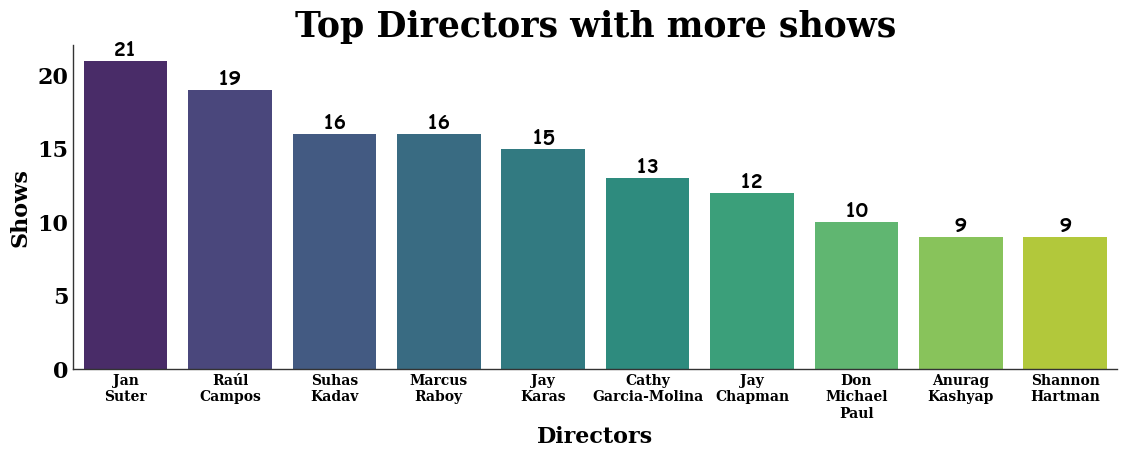

In [221]:
##----- Análisis de las columnas director, cast y listed_in

##------Director
top = df['director'].str.split(', ',expand=True).stack().value_counts(sort=True).head(11).reset_index().drop(0,axis=0)

fig, ax = plt.subplots(figsize=(12,4))
bar = sns.barplot(data=top,x='index',y='count',hue='index',palette='viridis')
def estetica_individual(titulo):
    ax.spines[['top','right']].set_visible(False)
    ax.set_title(f'Top {titulo} with more shows')
    ax.set_xlabel(titulo)
    ax.set_ylabel('Shows')
    labels = [i.replace(' ','\n') for i in top.iloc[:,0]]
    ax.set_xticks(range(len(labels)))
    ax.set_xticklabels(labels)

    for container in bar.containers:
        ax.bar_label(container,fontfamily='cursive',fontweight='bold',fontsize=14)
    
estetica_individual('Directors')

plt.show()

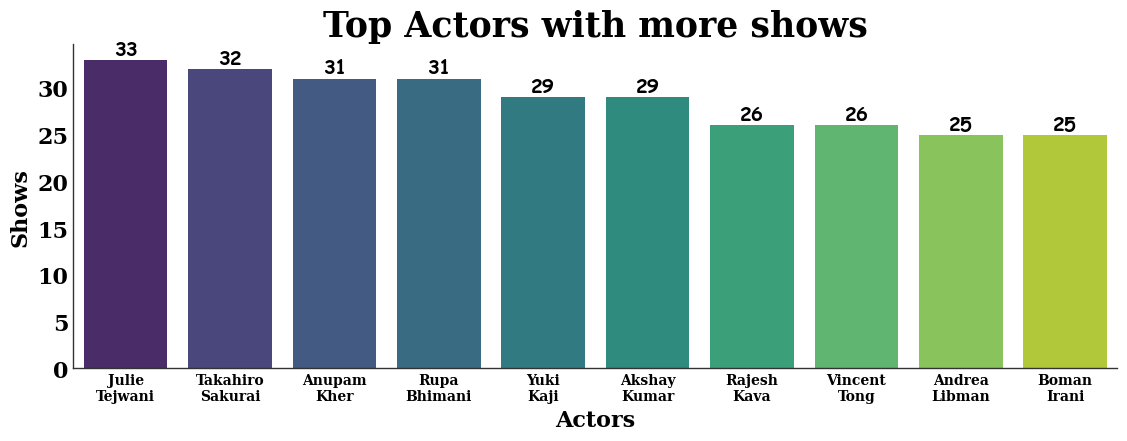

In [222]:
top = df['cast'].str.split(', ',expand=True).stack().value_counts(sort=True).head(11).reset_index().drop(0,axis=0)

fig, ax = plt.subplots(figsize=(12,4))
bar = sns.barplot(data=top,x='index',y='count',hue='index',palette='viridis')
def estetica_individual(titulo):
    ax.spines[['top','right']].set_visible(False)
    ax.set_title(f'Top {titulo} with more shows')
    ax.set_xlabel(titulo)
    ax.set_ylabel('Shows')
    labels = [i.replace(' ','\n') for i in top.iloc[:,0]]
    ax.set_xticks(range(len(labels)))
    ax.set_xticklabels(labels)

    for container in bar.containers:
        ax.bar_label(container,fontfamily='cursive',fontweight='bold',fontsize=14)
    
estetica_individual('Actors')

plt.show()

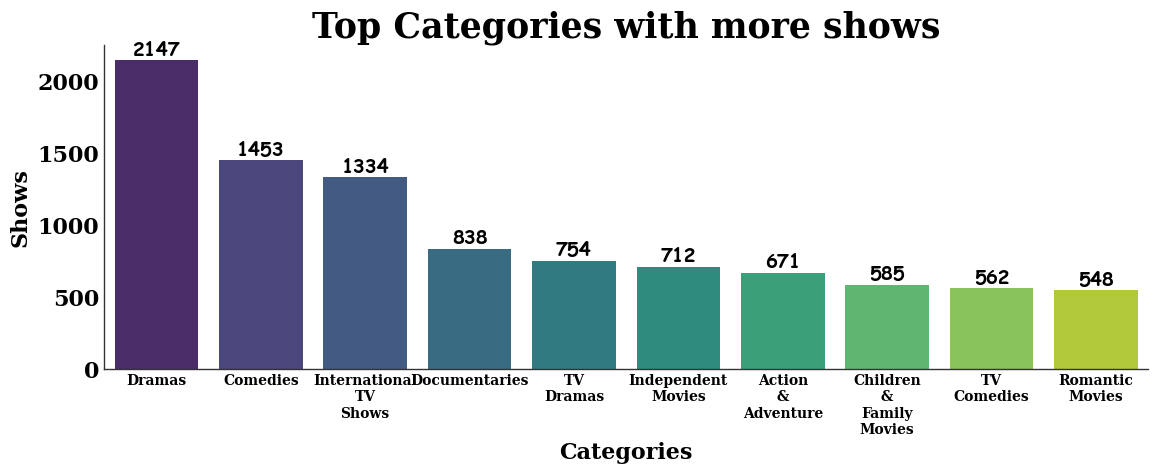

In [223]:
top = df['listed_in'].str.split(', ',expand=True).stack().value_counts(sort=True).head(11).reset_index().drop(0,axis=0)

fig, ax = plt.subplots(figsize=(12,4))
bar = sns.barplot(data=top,x='index',y='count',hue='index',palette='viridis')
def estetica_individual(titulo):
    ax.spines[['top','right']].set_visible(False)
    ax.set_title(f'Top {titulo} with more shows')
    ax.set_xlabel(titulo)
    ax.set_ylabel('Shows')
    labels = [i.replace(' ','\n') for i in top.iloc[:,0]]
    ax.set_xticks(range(len(labels)))
    ax.set_xticklabels(labels)

    for container in bar.containers:
        ax.bar_label(container,fontfamily='cursive',fontweight='bold',fontsize=14)
    
estetica_individual('Categories')


plt.show()

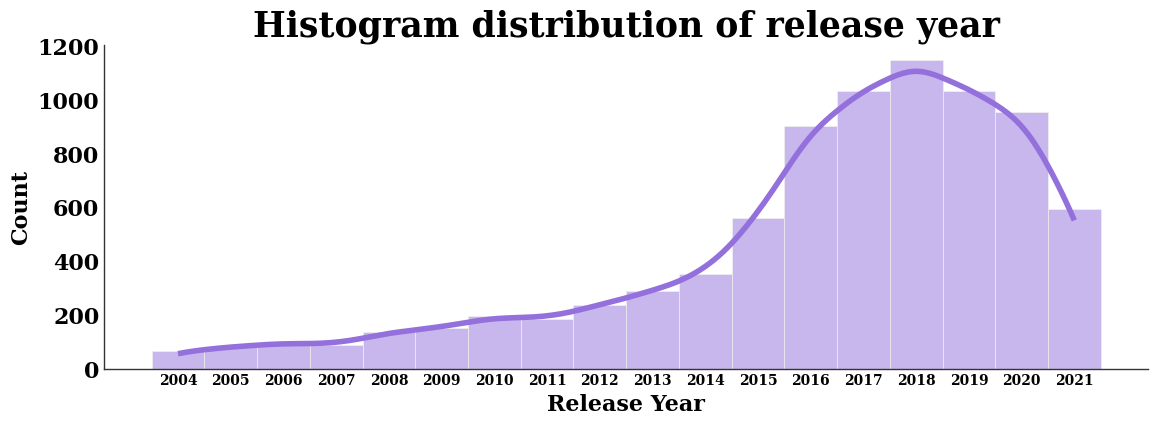

In [224]:
##-----Distribucion de los datos de año de estreno

fig, ax = plt.subplots(figsize=(12,4))

release = df['release_year']

sns.histplot(data=release,bins=25,discrete=True,kde=True,color='mediumpurple')
ax.spines[['top','right']].set_visible(False)
ax.set_title('Histogram distribution of release year')
ax.set_xticks(release.unique())
ax.set_xlabel('Release Year')

plt.show()

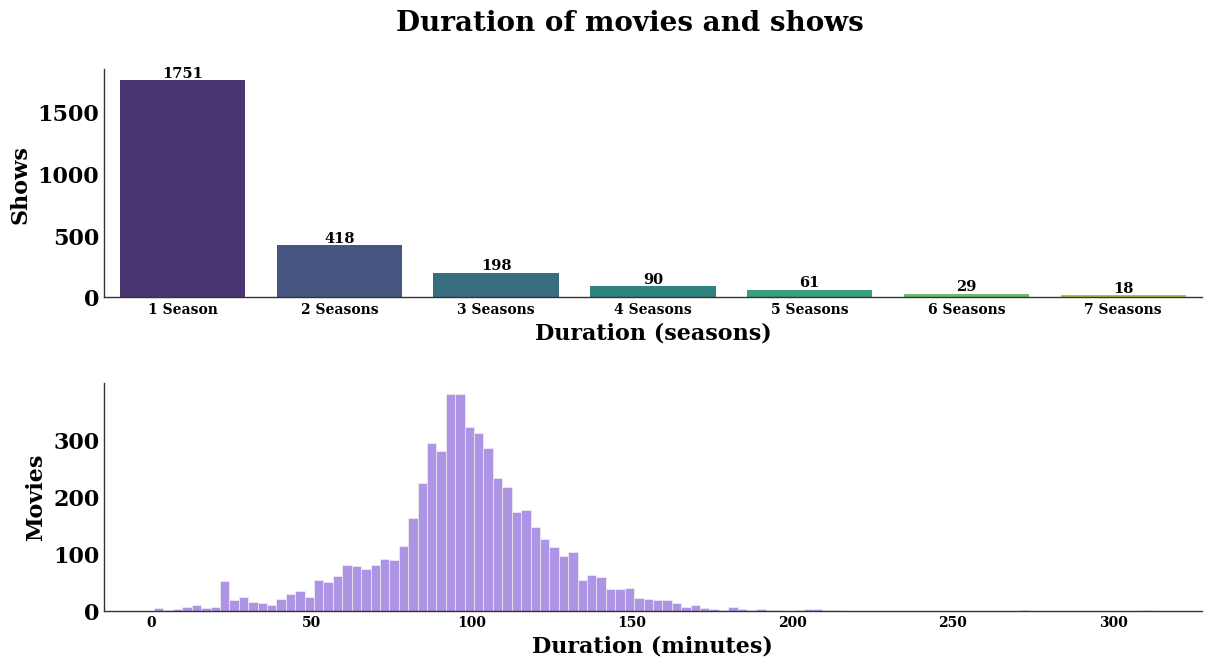

In [262]:
##-----Distribucion de la duracion de series y peliculas

movies = df.loc[df['type']=='Movie'].drop(columns='type')
shows = df.loc[df['type']=='TV Show'].drop(columns='type')

seasons = shows['duration'].value_counts(sort=True).head(7).reset_index()
minutes = movies['duration'].str.split(expand=True).drop(columns=1).astype(np.int16)


fig, ax = plt.subplots(figsize=(12,6),nrows=2)
fig.tight_layout(h_pad=4)
fig.suptitle('Duration of movies and shows',y=1.06)
bar = sns.barplot(data=seasons,ax=ax[0],x='duration',y='count',hue='duration',palette='viridis')
sns.histplot(data=minutes,ax=ax[1],x=0,color='mediumpurple')

ax[1].set_xlabel('Duration (minutes)')
ax[0].set_xlabel('Duration (seasons)')
ax[0].set_ylabel('Shows')
ax[1].set_ylabel('Movies')
for i in range(2):
    ax[i].spines[['top','right']].set_visible(False)
    
for container in bar.containers:
    ax[0].bar_label(container)


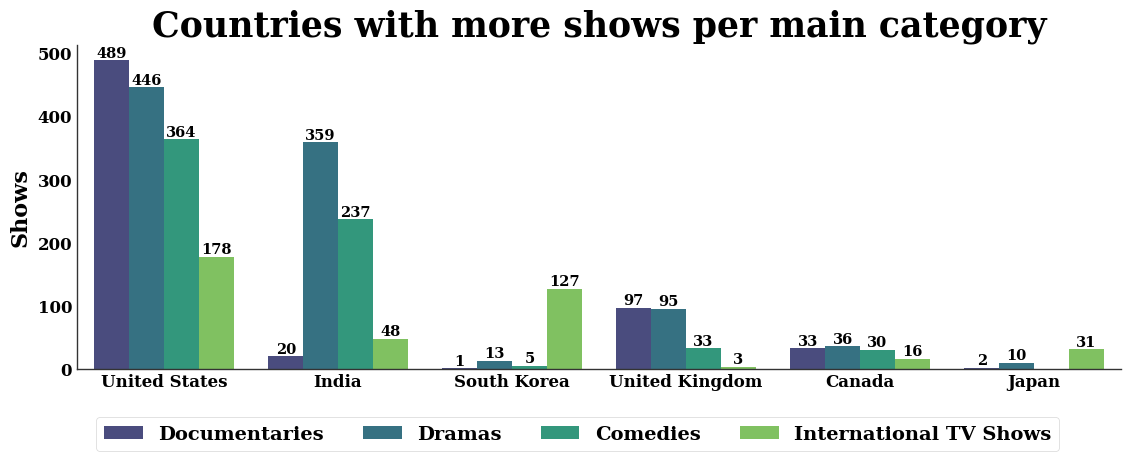

In [345]:
###Categoría de cada show por pais

##Es necesario crear una columna con la categoría principal de cada show
df['main_cat'] = df['listed_in'].str.split(', ',expand=True)[0]
df['country'] = df['country'].str.split(', ',expand=True)[0]

##Paso 1: Hallar los paises con más producciones y el tipo de show más comun
top_countries = df['country'].value_counts(sort=True).head(6)
top_countries = top_countries.index

top_main_cat = df['main_cat'].value_counts(sort=True).head(4)
top_main_cat = top_main_cat.index

##Paso 2: Obtener un df con informacion de esos paises 
df_countries = df.loc[df['country'].isin(top_countries)]
##Paso 3: agrupar los datos y filtrar de nuevo
country_category = df_countries.groupby(['country','main_cat'])['type'].count().reset_index()
country_category = country_category.loc[country_category['main_cat'].isin(top_main_cat)].sort_values(by='type',ascending=False)
##Paso 4: graficar
fig, ax = plt.subplots(figsize=(12,4))
bar = sns.barplot(data=country_category,x='country',y='type',hue='main_cat',palette='viridis')

for container in bar.containers:
    ax.bar_label(container)

ax.spines[['top','right']].set_visible(False)
ax.legend(bbox_to_anchor=(0.95,-0.12),ncols=4)
ax.set_xlabel('')
ax.set_ylabel('Shows')
ax.set_title('Countries with more shows per main category')
ax.tick_params(axis='both',labelsize=12)
plt.show()

## Proceso de Machine Learning

In [356]:
##-----El objetivo es predecir la cantidad de temporadas que tendrá una serie a partir de las demás variables

###Vamos a obtener una columna donde solo esté el actor principal de cada show y la cantidad de temporadas

df['actor'] = df['cast'].str.split(', ',expand=True)[0]
df['seasons'] = df['duration'].str.split(' ',expand=True)[0]

shows = df.loc[df['type']=='TV Show'].drop(columns=['type','listed_in','cast','duration']).sort_index(axis=1)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

##Paso 1: codificar las variables para que sean numéricas

# variables_cat = df_filtered.select_dtypes('O')

# label = LabelEncoder()

# for col in variables_cat:
#     df_filtered[col] = label.fit_transform(df_filtered[col].astype(str))
shows

,actor,country,date_added,director,main_cat,rating,release_year,seasons,year_to_netflix
1,Ama Qamata,South Africa,2021-09-24,Rajiv Chilaka,International TV Shows,TV-MA,2021,2,0
2,Sami Bouajila,United States,2021-09-24,Julien Leclercq,Crime TV Shows,TV-MA,2021,1,0
3,David Attenborough,United States,2021-09-24,Rajiv Chilaka,Docuseries,TV-MA,2021,1,0
4,Mayur More,India,2021-09-24,Rajiv Chilaka,International TV Shows,TV-MA,2021,2,0
5,Kate Siegel,United States,2021-09-24,Mike Flanagan,TV Dramas,TV-MA,2021,1,0
...,...,...,...,...,...,...,...,...,...
8795,Mike Liscio,Japan,2018-05-01,Rajiv Chilaka,Anime Series,TV-Y7,2015,2,3
8796,Gökhan Atalay,Turkey,2017-01-17,Rajiv Chilaka,International TV Shows,TV-PG,2016,2,1
8797,Michael Johnston,United States,2018-09-13,Rajiv Chilaka,Kids' TV,TV-Y7,2016,3,2
8800,Sanam Saeed,Pakistan,2016-12-15,Rajiv Chilaka,International TV Shows,TV-PG,2012,1,4


<Axes: >

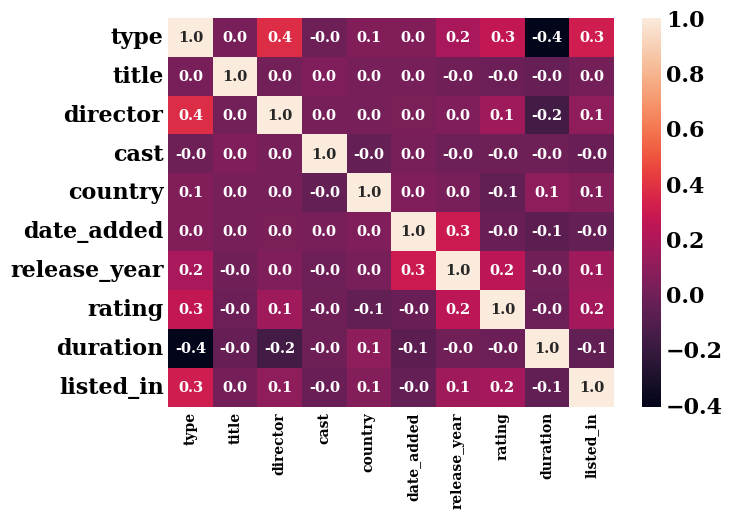

In [40]:
##Determinar correlaciones

sns.heatmap(df_filtered.corr(),annot=True,fmt='.1f')

### Insight 1: Determinar la relación entre duration, año de estreno y rating de las películas

In [49]:
df_films = df_filtered.loc[df_filtered['type']==0]

##Librerías 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


##Modelo de regresion lineal simple

linear = LinearRegression()

x = df_films[['duration','release_year']]
y = df_films['rating']

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.25,random_state=3)

linear.fit(x_train,y_train)

y_pred = linear.predict(x_test)

##Evaluar el modelo

mse = mean_squared_error(y_test,y_pred)
mae = mean_absolute_error(y_test,y_pred)
r2 = r2_score(y_test,y_pred)

print('El rendimiento del modelo fue: ', f'\nMSE = {mse:.3f}\nMAE = {mae:.3f}\nR2 = {r2:.3f}')

El rendimiento del modelo fue:  
MSE = 3.420
MAE = 1.512
R2 = 0.073


In [69]:
##Modelo de regresion polinomial y ajuste de hiperparámetros

from sklearn.preprocessing import PolynomialFeatures

pol = PolynomialFeatures(degree=3)

x_pol = pol.fit_transform(x)

x_train, x_test, y_train, y_test = train_test_split(x_pol, y,test_size=0.25,random_state=123)

polinomial = LinearRegression()

polinomial.fit(x_train,y_train)

y_pred = polinomial.predict(x_test)

##Evaluar el modelo

mse = mean_squared_error(y_test,y_pred)
r2 = r2_score(y_test,y_pred)

print('Rendimiento del modelo antes del ajuste de hiperparámetros:\n',f'\bMSE: {mse:.2f}\nR2: {r2:.2f}')


Rendimiento del modelo antes del ajuste de hiperparámetros:
MSE: 3.26
R2: 0.16


In [65]:
##Prediccion usando Random Forest y ajuste de hiperparámetros

from sklearn.ensemble import RandomForestRegressor

random = RandomForestRegressor(n_estimators=100, random_state=123)

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.25,random_state=123)

random.fit(x_train,y_train)

y_pred = random.predict(x_test)

##Evaluar el rendimiento

mse = mean_squared_error(y_test,y_pred)
r2 = r2_score(y_test,y_pred)

print(f'El rendimiento antes de ajustar los hiperparámetros es:\nMSE: {mse:.2f}\nR2: {r2:.2f}')


###Ajuste de hiperparámetros


from sklearn.model_selection import GridSearchCV

parametros = {

    'n_estimators':[50,100,200],
    'max_depth':[None,10,20,30],
    'min_samples_split':[2,5,10],
    'min_samples_leaf':[1,2,4],
    'max_features':['auto','sqrt']
}

random = RandomForestRegressor(random_state=456)

grid_search = GridSearchCV(estimator=random,param_grid=parametros,cv=5,n_jobs=-1,verbose=2, scoring='neg_mean_squared_error')


x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.25,random_state=456)

grid_search.fit(x_train,y_train)

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test)

mse = mean_squared_error(y_test,y_pred)
r2 = r2_score(y_test,y_pred)

print(f'El rendimiento después de ajustar los hiperparámetros es:\nMSE: {mse:.2f}\nR2: {r2:.2f}')



El rendimiento antes de ajustar los hiperparámetros es:
MSE: 3.95
R2: -0.02
Fitting 5 folds for each of 216 candidates, totalling 1080 fits


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
540 fits failed out of a total of 1080.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
67 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py"

El rendimiento después de ajustar los hiperparámetros es:
MSE: 3.28
R2: 0.15


## Conclusión

* Fueron usados 3 modelos de Machine Learning para predecir los puntajes de shows de Netflix a partir del año de estreno y duración de las películas. El mejor modelo fue el de Regresión polinomial con un R cuadrado de 0.16. Es decir, el modelo puede explicar aproximadamente el 16% de la variación de los valores del Rating. 
* El modelo sugiere que la duración y el año de estreno tienen un impacto significativo en el rating.
* La información podría ser de ayuda para Netflix en su selección de contenido y estrategias de Marketing para estimar el potencial de éxito de sus películas según la fecha de estreno